In [17]:
%pylab inline
from astropy.io import fits
import astropy.units as u
import pickle as pickle
import os as os

from spectools_ir.utils import extract_hitran_data, spec_convol, make_rotation_diagram, get_molmass
from spectools_ir.utils import compute_thermal_velocity, sigma_to_fwhm, fwhm_to_sigma, wn_to_k
from spectools_ir.flux_calculator import calc_fluxes, make_lineshape

from spectools_ir.slabspec import make_spec

from spectools_ir.slab_fitter import Config, LineData,Retrieval
from spectools_ir.slab_fitter import corner_plot, trace_plot, find_best_fit, compute_model_fluxes, remove_burnin
from spectools_ir.slab_fitter import calc_solid_angle, calc_radius

Populating the interactive namespace from numpy and matplotlib


# Flux_calculator example use

### Read in HITRAN data with extract_hitran_data

In [2]:
hitran_data=extract_hitran_data('CO',4.58,5.2,vup=1)  #Outputs an astropy table

In [3]:
#Read in FITS data containing spectrum.
infile='AATau_M.fits'

hdulist=fits.open(infile)
data=hdulist[1].data
wave=data['WAVELENGTH'][0]*1e-3
flux=data['FLUX'][0]

Text(0, 0.5, 'Flux [Jy]')

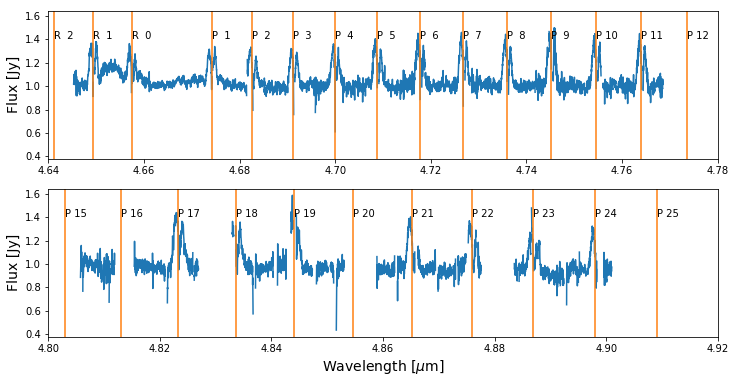

In [4]:
#Plot spectrum.
fig=plt.figure(figsize=(12,6))

ax1=fig.add_subplot(211)
ax1.plot(wave,flux)
ax1.set_xlim(4.64,4.78)
for i,mywave in enumerate(hitran_data['wave']):
    if( (mywave>4.64) & (mywave<4.78) ):
        ax1.axvline(mywave,color='C1')
        ax1.text(hitran_data['wave'][i],1.4,hitran_data['Qpp'][i].strip())
ax1.set_ylabel('Flux [Jy]',fontsize=14)

ax2=fig.add_subplot(212)
ax2.plot(wave,flux)
ax2.set_xlim(4.8,4.92)
for i,mywave in enumerate(hitran_data['wave']):
    if( (mywave>4.8) & (mywave<4.92) ):
        ax2.axvline(mywave,color='C1')
        ax2.text(hitran_data['wave'][i],1.4,hitran_data['Qpp'][i].strip())
ax2.set_xlabel('Wavelength [$\mu$m]',fontsize=14)
ax2.set_ylabel('Flux [Jy]',fontsize=14)

### Calculate line fluxes for dataset, using locations specified in hitran dataset

In [7]:
#Calculate fluxes.
#lineflux_data=calc_fluxes(wave,flux,hitran_data, v_dop=0,fwhm_v=40.,sep_v=200.,cont=1.05,vet_fits=True, plot=True)

#pickle.dump(lineflux_data,open('lineflux_data.p','wb')) #save for convenience
lineflux_data=pickle.load(open('lineflux_data.p','rb'))  #restore lineflux_data if you don't want to re-run

Note that flux_calculator calculates fluxes using both a Gaussian fit and numerical integration.  These values should be similar for Gaussian line shapes, but may be quite different for more complex line shapes, as for AA Tau.

Text(0, 0.5, 'Line flux [W m$^{-2}$]')

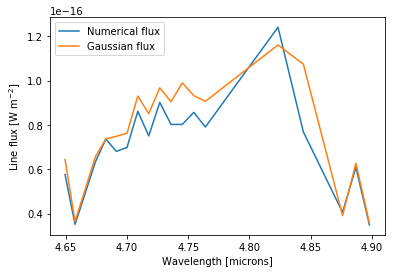

In [7]:
fig=plt.figure()
ax1=fig.add_subplot(111)
ax1.plot(lineflux_data['wave'],lineflux_data['lineflux'], label='Numerical flux')
ax1.plot(lineflux_data['wave'],lineflux_data['lineflux_Gaussian'] ,label='Gaussian flux')
ax1.legend()
ax1.set_xlabel('Wavelength [microns]')
ax1.set_ylabel(r'Line flux [W m$^{-2}$]')

Note that, although calc_fluxes takes a full "hitran_data" table as input, the most minimal table it can function with is one that just contains a column named "wave", which holds wavelengths in microns.

Not enough data near  5.188746452331543  microns. Skipping.
Not enough data near  5.174523830413818  microns. Skipping.
Not enough data near  5.160454273223877  microns. Skipping.
Not enough data near  5.146536350250244  microns. Skipping.
Not enough data near  5.132768630981445  microns. Skipping.
Not enough data near  5.119149684906006  microns. Skipping.
Not enough data near  5.105678558349609  microns. Skipping.
Not enough data near  5.092352867126465  microns. Skipping.
Not enough data near  5.079172134399414  microns. Skipping.
Not enough data near  5.066134452819824  microns. Skipping.
Not enough data near  5.053239345550537  microns. Skipping.
Not enough data near  5.040484428405762  microns. Skipping.
Not enough data near  5.02786922454834  microns. Skipping.
Not enough data near  5.015391826629639  microns. Skipping.
Not enough data near  5.003051280975342  microns. Skipping.
Not enough data near  4.990846633911133  microns. Skipping.
Not enough data near  4.978776931762695  

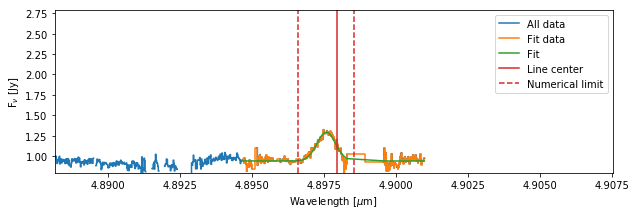

Is this fit okay? [y or n]n


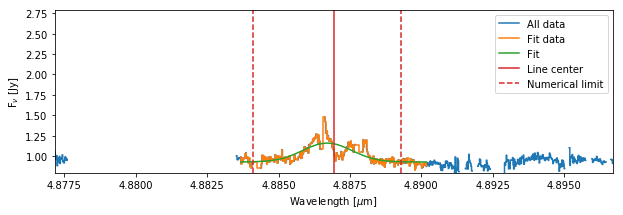

Is this fit okay? [y or n]t
Is this fit okay? Please enter y or n.y


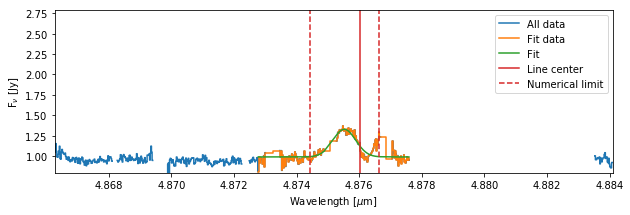

Is this fit okay? [y or n]n


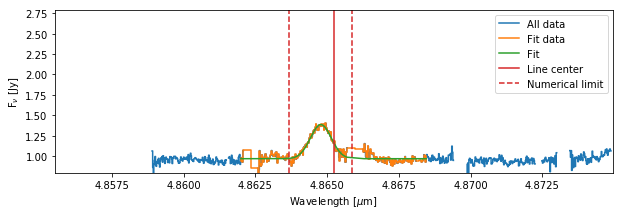

Is this fit okay? [y or n]n


/Users/cosalyk/mypy/spectools_ir/flux_calculator/helpers.py:188: RuntimeWarning: Mean of empty slice
  dwave=np.nanmean(np.diff(myx[mybool]))


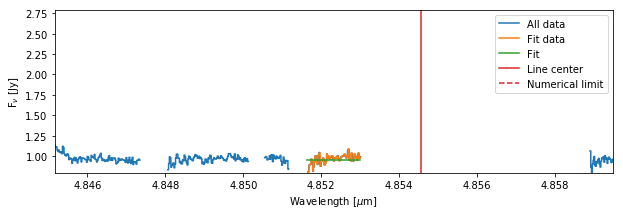

Is this fit okay? [y or n]n


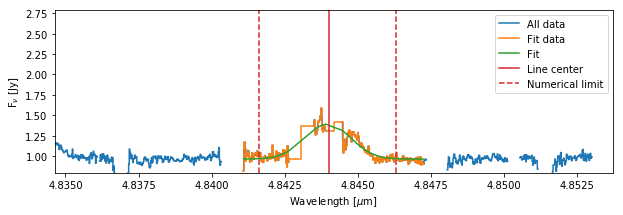

Is this fit okay? [y or n]y
Error - curve_fit failed


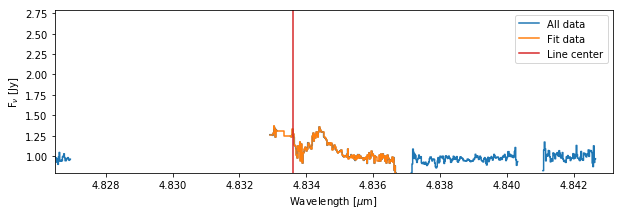

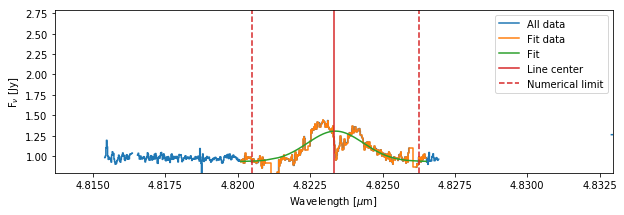

Is this fit okay? [y or n]y


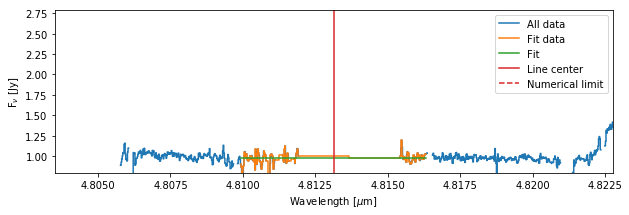

Is this fit okay? [y or n]n


/Users/cosalyk/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:787: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


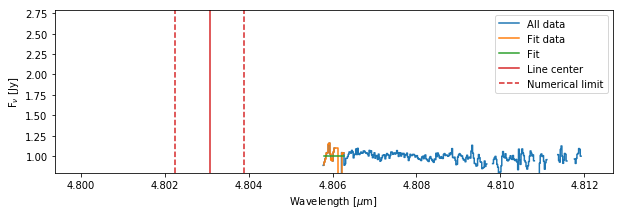

Is this fit okay? [y or n]n
Not enough data near  4.793123722076416  microns. Skipping.
Not enough data near  4.78329610824585  microns. Skipping.
Not enough data near  4.77358341217041  microns. Skipping.


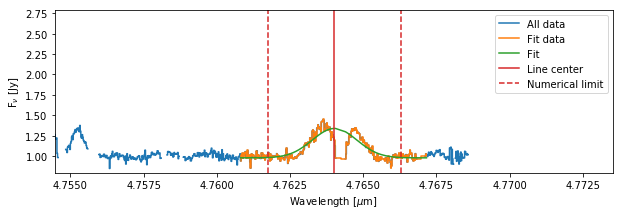

Is this fit okay? [y or n]y


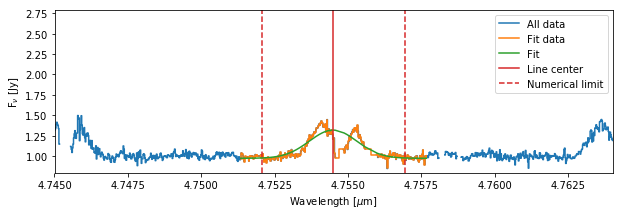

Is this fit okay? [y or n]y


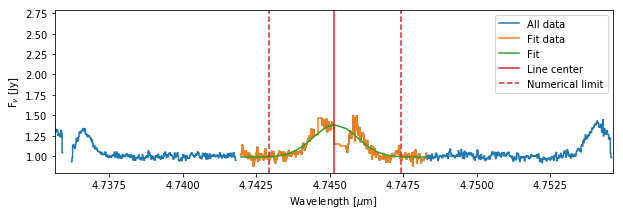

Is this fit okay? [y or n]y


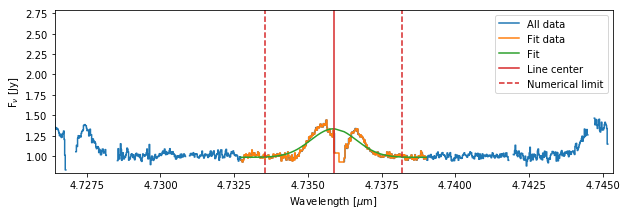

Is this fit okay? [y or n]y


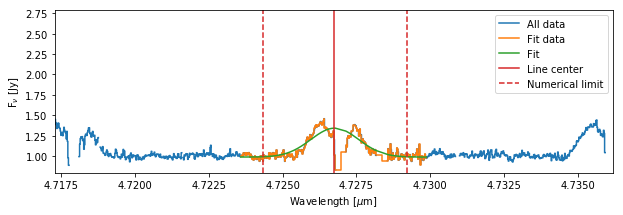

Is this fit okay? [y or n]y


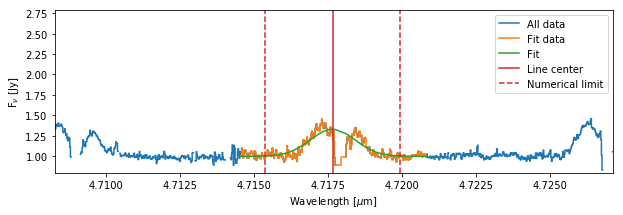

Is this fit okay? [y or n]y


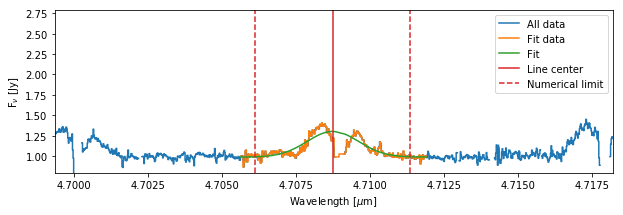

Is this fit okay? [y or n]y


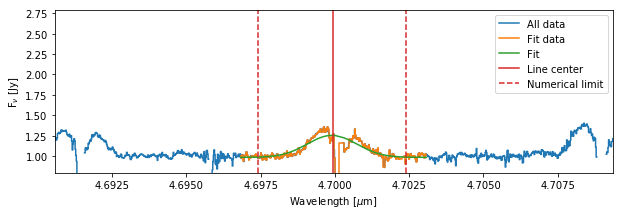

Is this fit okay? [y or n]y


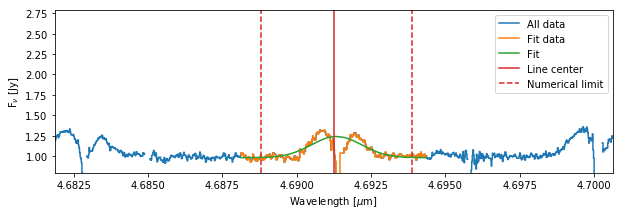

Is this fit okay? [y or n]y


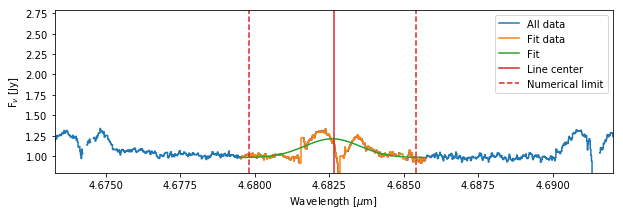

Is this fit okay? [y or n]y


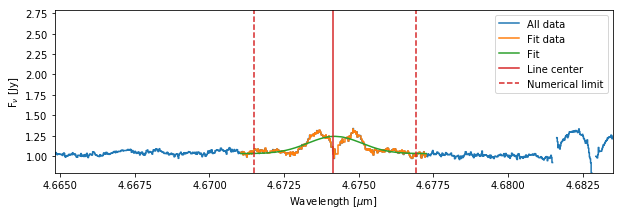

Is this fit okay? [y or n]y


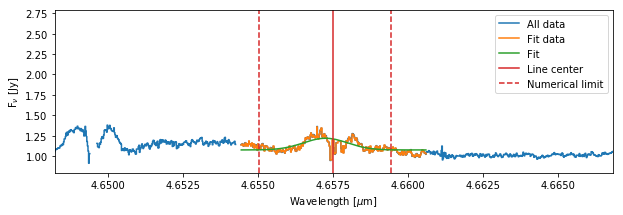

Is this fit okay? [y or n]y


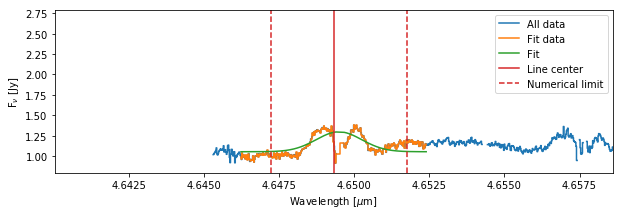

Is this fit okay? [y or n]y
Not enough data near  4.641242027282715  microns. Skipping.
Not enough data near  4.633276462554932  microns. Skipping.
Not enough data near  4.625414848327637  microns. Skipping.
Not enough data near  4.6176557540893555  microns. Skipping.
Not enough data near  4.60999870300293  microns. Skipping.
Not enough data near  4.602443695068359  microns. Skipping.
Not enough data near  4.594989776611328  microns. Skipping.
Not enough data near  4.5876359939575195  microns. Skipping.
Not enough data near  4.580382347106934  microns. Skipping.


In [8]:
test_hitran_data=hitran_data[['wave']].copy()

test_lineflux_data=calc_fluxes(wave,flux,test_hitran_data,v_dop=0,fwhm_v=40.,sep_v=200.,cont=1.05,vet_fits=True, plot=True)

### Create a composite lineshape using info from flux_calculator output

In [12]:
lineshape_data=make_lineshape(wave,flux,lineflux_data)

Text(0, 0.5, 'Arbitrary flux')

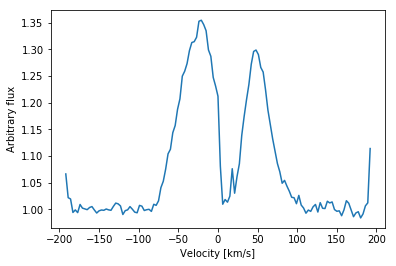

In [14]:
fig=plt.figure()
ax1=fig.add_subplot(111)
ax1.plot(lineshape_data[0],lineshape_data[1])

ax1.set_xlabel('Velocity [km/s]')
ax1.set_ylabel('Arbitrary flux')

### Display resultant fluxes in a rotation diagram

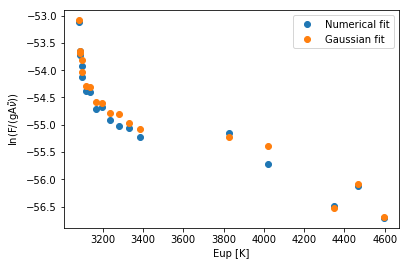

In [16]:
rot_numerical=make_rotation_diagram(lineflux_data,fluxkey='lineflux')
rot_Gaussian=make_rotation_diagram(lineflux_data,fluxkey='lineflux_Gaussian')

fig=plt.figure()
ax1=fig.add_subplot(111)
ax1.plot(rot_numerical['x'],rot_numerical['y'],'C0o',label='Numerical fit')
ax1.plot(rot_Gaussian['x'],rot_Gaussian['y'],'C1o', label='Gaussian fit')

ax1.set_xlabel('Eup [K]')
ax1.set_ylabel(r'ln(F/(gA$\tilde{\nu}$))')
ax1.legend()

# Slabspec example use

### Make a slab model spectrum with make_spec

In [4]:
au=1.5e11
model_output=make_spec('CO',1e22,1000,np.pi*(0.3*au)**2., wmin=4.58,wmax=5.2,convol_fwhm=30.,d_pc=140.,res=1e-5,vup=1)

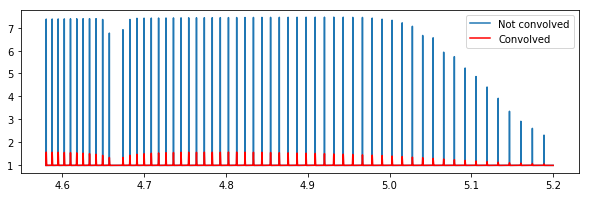

In [5]:
fig=plt.figure(figsize=(10,3))
ax1=fig.add_subplot(111)
ax1.plot(model_output['spectrum']['wave'],model_output['spectrum']['flux']+1,label='Not convolved')
ax1.plot(model_output['spectrum']['wave'],model_output['spectrum']['convolflux']+1,'r',label='Convolved')
ax1.legend()

### Output model fluxes as a rotation diagram (compare to data if desired)

In [8]:
rd_model=make_rotation_diagram(model_output['lineparams'])
rd_data=make_rotation_diagram(lineflux_data)

(-57, -52.5)

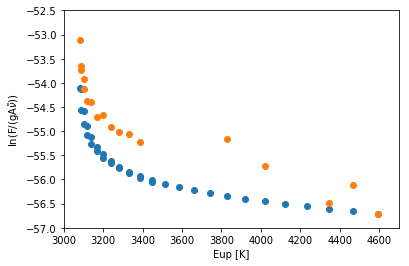

In [9]:
fig=plt.figure()
ax1=fig.add_subplot(111)
ax1.plot(rd_model['x'],rd_model['y'],' C0o',label='Model')
ax1.plot(rd_data['x'],rd_data['y'],' C1o',label='Data')
ax1.set_xlabel('Eup [K]')
ax1.set_ylabel(r'ln(F/(gA$\tilde{\nu}$))')
ax1.set_xlim(3000,4700)
ax1.set_ylim(-57,-52.5)

# Slab_fitter example use

### Set up configuration

In [10]:
myconfig=Config()  #reads config.json by default, or can specify path to file
myconfig.display()

data=lineflux_data

mydata=LineData(data)
myretrieval=Retrieval(myconfig,mydata)

{
 "tmin": 100,
 "tmax": 2000,
 "lognmin": 19,
 "lognmax": 24,
 "logomegamin": -19,
 "logomegamax": -12,
 "Nwalkers": 20,
 "Nburnin": 10000,
 "Nsamples": 3000
}


### Run retrieval

In [11]:
#postsamples=myretrieval.run_emcee()  #Run retrieval.  Can take >18 minutes on personal machine
#pickle.dump(postsamples,open('test_samples.p','wb'))  #Save for convenience and later retrieval
#os.system('afplay /System/Library/Sounds/Sosumi.aiff')

tempsamples=pickle.load(open('test_samples.p','rb'))  
postsamples=remove_burnin(tempsamples,myconfig.getpar('Nburnin')*3)  #Remove burn-in

### Evaluate retrieval results

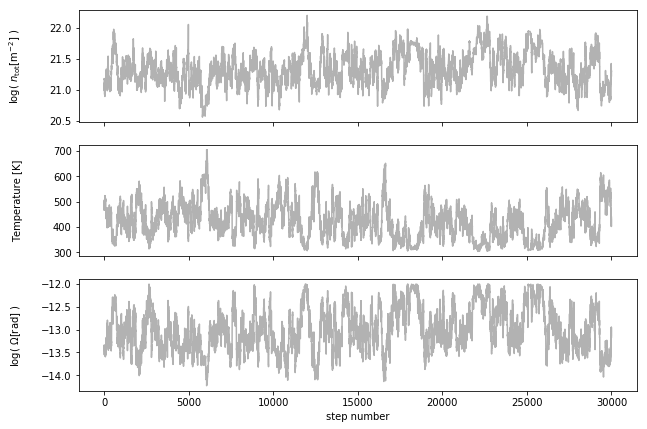

In [6]:
#Trace plot
trace_plot(postsamples)

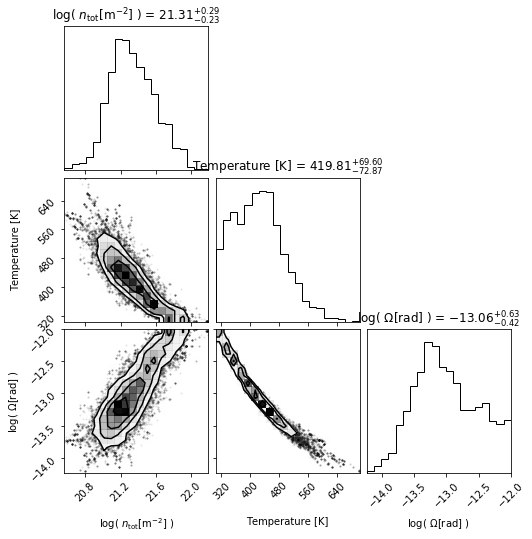

In [7]:
#Corner plot
fig=corner_plot(postsamples)

In [8]:
#Best fit parameters
best_fit=find_best_fit(postsamples,show=True)

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

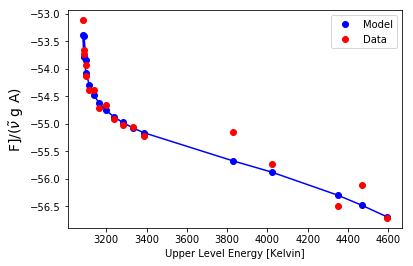

In [9]:
#Rotation diagram
modelflux=compute_model_fluxes(mydata,postsamples) #Compute model fluxes for ecah line in data
rotdiag=mydata.rot_diagram(modelfluxes=modelflux,units='mks') #Rotation diagram for data and model

fig=plt.figure()
ax1=fig.add_subplot(111)
ax1.plot(rotdiag['x'],rotdiag['modely'],'bo',label='Model')
ax1.plot(rotdiag['x'],rotdiag['modely'],'b',label='_None_')
ax1.plot(rotdiag['x'],rotdiag['y'],'ro',label='Data')

ax1.set_xlabel('Upper Level Energy [Kelvin]')
#ax1.set_ylabel(r'F[W m$^{-2}$]/($\~{\nu}$ [m$^{-1}$]g A[s$^{-1}$])',fontsize=14)
ax1.set_ylabel(r'F]/($\~{\nu}$ g A)',fontsize=14)
ax1.legend()

In [10]:
best_fit=find_best_fit(postsamples,show=True)

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

# Slab fitter test with slabspec output

In [23]:
au=1.5e11 #meters
model_output=make_spec('CO',1e22,1000,np.pi*(0.3*au)**2., wmin=4.58,wmax=5.2,convol_fwhm=30.,d_pc=140.,res=1e-5,vup=1)
np.log10(calc_solid_angle(0.3,140.))

-15.469714771476418

In [24]:
model_data=model_output['lineparams'].copy()
model_data['lineflux_err']=model_data['lineflux']*0.1

In [26]:
myconfig=Config('/Users/cosalyk/mypy/spectools_ir/slab_fitter/slabtest_config.json')  #reads config.json by default, or can specify path to file
myconfig.display()

mydata=LineData(model_data)
myretrieval=Retrieval(myconfig,mydata)

{
 "tmin": 100,
 "tmax": 1500,
 "lognmin": 20,
 "lognmax": 24,
 "logomegamin": -19,
 "logomegamax": -12,
 "Nwalkers": 20,
 "Nburnin": 10000,
 "Nsamples": 3000
}


In [27]:
#Run retrieval

#postsamples=myretrieval.run_emcee()  #Run retrieval.  Can take >18 minutes on personal machine
#pickle.dump(postsamples,open('slabspec_test_samples.p','wb'))  #Save for convenience and later retrieval
#os.system('afplay /System/Library/Sounds/Sosumi.aiff')

tempsamples=pickle.load(open('slabspec_test_samples.p','rb'))  
postsamples=remove_burnin(tempsamples,myconfig.getpar('Nburnin'))  #Remove burn-in

Number of total samples: 60000
Run time [s]: 1452.257622718811


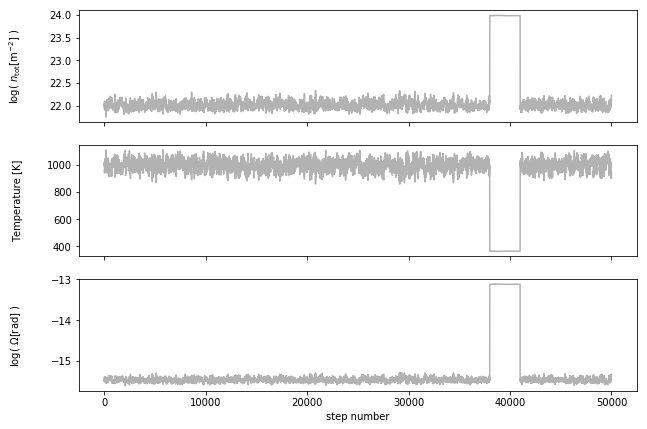

In [29]:
trace_plot(postsamples)

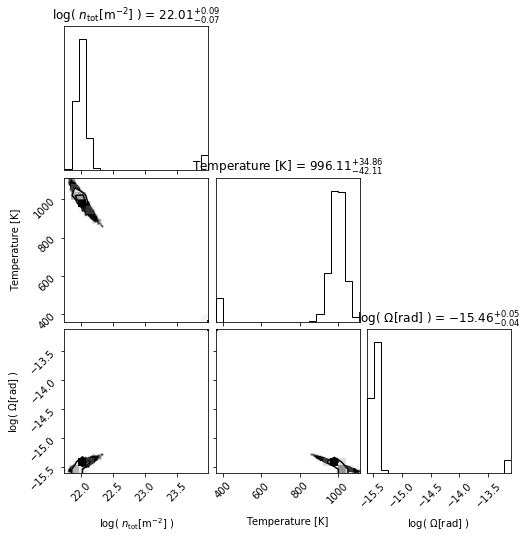

In [28]:
#Corner plot
fig=corner_plot(postsamples)

In [30]:
best_fit=find_best_fit(postsamples,show=True)

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

# Example use of other utils functions

### Extract HITRAN data for any molecule in the database

In [3]:
hitran_data=extract_hitran_data('H2O',10,11,isotopologue_number=2,eupmax=5000,aupmin=0.1)  #Outputs an astropy table

In [4]:
hitran_data

molec_id,local_iso_id,wn,sw,a,gamma_air,gamma_self,elower,n_air,delta_air,Vp,Vpp,Qp,Qpp,ierr1,ierr2,ierr3,ierr4,ierr5,ierr6,iref1,iref2,iref3,iref4,iref5,iref6,line_mixing_flag,gp,gpp,nu,eup_k,wave
int32,int32,float32,float32,float32,float32,float32,float32,float32,float32,bytes15,bytes15,bytes15,bytes15,int32,int32,int32,int32,int32,int32,int32,int32,int32,int32,int32,int32,bytes1,float32,float32,float32,float32,float32
1,2,920.7934,4.16e-27,0.5857,0.0724,0.307,2541.1726,0.71,0.01332,0 0 0,0 0 0,15 6 9,14 3 12,5,7,4,8,4,0,54,36,67,1,18,6,,93.0,87.0,27604692000000.0,4980.996,10.8602
1,2,930.6551,2.78e-27,0.1575,0.0419,0.207,2305.3064,0.65,-0.008219,0 0 0,0 0 0,12 10 3,11 7 4,5,7,3,8,4,0,48,36,67,1,18,6,,75.0,69.0,27900338000000.0,4655.826,10.745119
1,2,930.76526,9.27e-28,0.1575,0.037,0.215,2305.1958,0.65,-0.011539,0 0 0,0 0 0,12 10 2,11 7 5,5,7,3,4,4,0,54,36,74,67,18,29,,25.0,23.0,27903641000000.0,4655.825,10.743848
1,2,942.27203,3.27e-27,0.1311,0.0732,0.334,2033.8177,0.7,0.01508,0 0 0,0 0 0,14 5 9,13 2 12,5,7,5,8,4,0,54,36,67,1,18,6,,29.0,27.0,28248606000000.0,4281.9287,10.612646
1,2,949.1905,9.59e-27,0.1116,0.0405,0.235,1954.6537,0.69,-0.004629,0 1 0,0 0 0,11 0 11,12 3 10,5,6,5,6,4,1,48,36,67,1,24,6,,69.0,75.0,28456016000000.0,4177.9834,10.535293
1,2,951.1828,3.25e-27,0.1128,0.0407,0.241,1952.6779,0.44,6e-05,0 1 0,0 0 0,11 1 11,12 2 10,5,6,5,8,4,1,48,36,67,1,22,6,,23.0,25.0,28515743000000.0,4178.0073,10.5132265
1,2,955.3522,8.59e-28,0.2641,0.037,0.243,2416.783,0.41,-0.005049,0 1 0,0 0 0,12 1 11,13 4 10,5,6,5,4,4,6,48,36,61,67,22,24,,25.0,27.0,28640738000000.0,4851.75,10.467344
1,2,957.3615,3.79e-27,0.1135,0.0529,0.249,1952.6779,0.59,0.01336,0 0 0,0 0 0,13 7 7,12 2 10,5,7,5,7,4,6,48,36,61,1,18,37,,27.0,25.0,28700976000000.0,4186.897,10.445375
1,2,965.64764,2.82e-27,0.2811,0.0455,0.255,2406.77,0.41,0.00298,0 1 0,0 0 0,12 2 11,13 3 10,5,6,5,7,4,6,48,36,67,1,22,24,,75.0,81.0,28949388000000.0,4852.1562,10.355744


### Convolve a spectrum with a Gaussian spectral response function

Note: Convolving a spectrum is conceptually simple, but edge effects and NaNs in spectral data can cause headaches.  This routine deals nicely with both of those issues.

In [5]:
au=1.5e11
model_output=make_spec('CO',1e22,1000,np.pi*(0.3*au)**2., wmin=4.6,wmax=4.62,d_pc=140.,res=1e-5)
wave=model_output['spectrum']['wave']
flux=model_output['spectrum']['flux']
convolflux=spec_convol(wave,flux,30.)

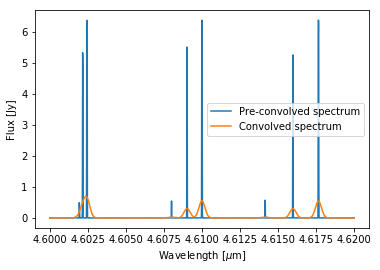

In [6]:
fig=plt.figure()
ax1=fig.add_subplot(111)
ax1.plot(wave,flux,label='Pre-convolved spectrum')
ax1.plot(wave,convolflux,label='Convolved spectrum')
ax1.set_xlabel(r'Wavelength [$\mu$m]')
ax1.set_ylabel('Flux [Jy]')
ax1.legend()

### Other small helper functions

In [23]:
print(sigma_to_fwhm(20.))

print(fwhm_to_sigma(47.096))

print(get_molmass('H2O',isotopologue_number=2))

print(compute_thermal_velocity('H2',500.))
print(compute_thermal_velocity('H2',1000.))

print(wn_to_k(2000./u.cm))

47.09640090061899
19.999829753182272
20.014811
1436.1325755292241
2030.998165679232
2877.553755007867 K


In [ ]:
#To do:
#Write a routine to do wavelength-dependent convolution